In [12]:
import pandas as pd
import numpy as np
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
import statistics
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


from IPython.display import HTML


In [13]:
import IPython.core.display as di

di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [14]:
# Connects to Mercury
# Selects booking requests data, where the delivery date is between 10th and 15th of February 2020
# Booking requests when order changes - look what fields are important

connection = pymysql.connect(host = 'localhost',
                            user = 'devs_readonly',
                            password = 'cvspOze7ti9lXN0NbpDPL8dxxuSV2bILp58v5swx',
                            db = 'hg_prod',
                            port = 3306
                            )

with connection.cursor() as cursor:
    sql = """SELECT *, COALESCE(raw_response ->'$.order.status' , raw_response ->'$.status') otl_status
             FROM job_updates 
             ORDER BY webhook_timestamp ASC
            """
    cursor.execute(sql)
    result = cursor.fetchall()
    colnames = [desc[0] for desc in cursor.description]

df = pd.DataFrame(result, columns = colnames)    

In [15]:
df.head()

update_id      id  booking_id courier_own_equipment  current_lat  \
0        512  136645    138112.0                  None          NaN   
1     131584  139351    140818.0                  None          NaN   
2        768  136331    137799.0                  None          NaN   
3     132096  137328    138790.0                  None          NaN   
4     263168  141286    142787.0                  None          NaN   

   current_lng current_state date_arrived_at_dropoff date_arrived_at_pickup  \
0          NaN          None                     NaT                    NaT   
1          NaN          None                     NaT                    NaT   
2          NaN          None                     NaT                    NaT   
3          NaN          None                     NaT                    NaT   
4          NaN          None                     NaT                    NaT   

  date_assigned date_completed date_created date_dropped_off  \
0           NaT            NaT          NaT              NaT   
1           NaT            NaT          NaT              NaT   
2           NaT            NaT          NaT              NaT   
3           NaT            NaT          NaT              NaT   
4           NaT            NaT          NaT              NaT   

  date_enroute_to_dropoff date_enroute_to_pickup date_picked_up  \
0                     NaT                    NaT            NaT   
1                     NaT                    NaT            NaT   
2                     NaT                    NaT            NaT   
3                     NaT                    NaT            NaT   
4                     NaT                    NaT            NaT   

  delivery_provider driver_name driver_phone  dropoff_lat  dropoff_lng  \
0              None        None         None          NaN          NaN   
1              None        None         None          NaN          NaN   
2              None        None         None          NaN          NaN   
3              None        None         None          NaN          NaN   
4              None        None         None          NaN          NaN   

  dropoff_tracking_url  dropoff_window_end dropoff_window_start eta_dropoff  \
0                 None 2020-09-08 11:30:00  2020-09-08 11:00:00         NaT   
1                 None 2020-10-01 11:30:00  2020-10-01 10:45:00         NaT   
2                 None                 NaT                  NaT         NaT   
3                 None                 NaT                  NaT         NaT   
4                 None                 NaT                  NaT         NaT   

  eta_dropoff_best_guess eta_dropoff_optimistic eta_dropoff_pessimistic  \
0                    NaT                    NaT                     NaT   
1                    NaT                    NaT                     NaT   
2    2020-09-08 07:31:02    2020-09-08 07:29:18     2020-09-08 07:32:04   
3                    NaT                    NaT                     NaT   
4    2020-10-13 10:13:57    2020-10-13 10:13:40     2020-10-13 10:16:19   

  eta_pickup last_tracking_update        last_updated  order_human_id  \
0        NaT                  NaT 2020-09-08 06:07:23        291605.0   
1        NaT                  NaT 2020-09-25 11:02:07        294179.0   
2        NaT                  NaT                 NaT        291460.0   
3        NaT                  NaT                 NaT        291005.0   
4        NaT                  NaT                 NaT        296078.0   

  partner_id  pickup_lat  pickup_lng pickup_tracking_url pickup_window_end  \
0       None         NaN         NaN                None               NaT   
1       None         NaN         NaN                None               NaT   
2       None         NaN         NaN                None               NaT   
3       None         NaN         NaN                None               NaT   
4       None         NaN         NaN                None               NaT   

  pickup_window_start raw_response

In [16]:
status = list(df['otl_status'])
status2 = []

for i in status:
    
    if 'delivery_arrived' in str(i):
        status2.append('at-dropoff')
    
    elif 'delivery_done' in str(i):
        status2.append('complete')
        
    elif 'delivery_started' in str(i):
        status2.append('enroute-to-dropoff')
        
    elif 'order_accepted' in str(i):
        status2.append('pending')
        
    elif 'order_assigned' in str(i):
        status2.append('assigned')
        
    elif 'order_cancelled' in str(i):
        status2.append('deleted')
    
    elif 'pickup_arrived' in str(i):
        status2.append('at-pickup')
        
    elif 'pickup_done' in str(i):
        status2.append('picked-up')
    
    elif 'pickup_started' in str(i):
        status2.append('enroute-to-pickup')
        
    else:
        status2.append(i)
        
df['otl_status_2'] = status2
df.head()

update_id      id  booking_id courier_own_equipment  current_lat  \
0        512  136645    138112.0                  None          NaN   
1     131584  139351    140818.0                  None          NaN   
2        768  136331    137799.0                  None          NaN   
3     132096  137328    138790.0                  None          NaN   
4     263168  141286    142787.0                  None          NaN   

   current_lng current_state date_arrived_at_dropoff date_arrived_at_pickup  \
0          NaN          None                     NaT                    NaT   
1          NaN          None                     NaT                    NaT   
2          NaN          None                     NaT                    NaT   
3          NaN          None                     NaT                    NaT   
4          NaN          None                     NaT                    NaT   

  date_assigned date_completed date_created date_dropped_off  \
0           NaT            NaT          NaT              NaT   
1           NaT            NaT          NaT              NaT   
2           NaT            NaT          NaT              NaT   
3           NaT            NaT          NaT              NaT   
4           NaT            NaT          NaT              NaT   

  date_enroute_to_dropoff date_enroute_to_pickup date_picked_up  \
0                     NaT                    NaT            NaT   
1                     NaT                    NaT            NaT   
2                     NaT                    NaT            NaT   
3                     NaT                    NaT            NaT   
4                     NaT                    NaT            NaT   

  delivery_provider driver_name driver_phone  dropoff_lat  dropoff_lng  \
0              None        None         None          NaN          NaN   
1              None        None         None          NaN          NaN   
2              None        None         None          NaN          NaN   
3              None        None         None          NaN          NaN   
4              None        None         None          NaN          NaN   

  dropoff_tracking_url  dropoff_window_end dropoff_window_start eta_dropoff  \
0                 None 2020-09-08 11:30:00  2020-09-08 11:00:00         NaT   
1                 None 2020-10-01 11:30:00  2020-10-01 10:45:00         NaT   
2                 None                 NaT                  NaT         NaT   
3                 None                 NaT                  NaT         NaT   
4                 None                 NaT                  NaT         NaT   

  eta_dropoff_best_guess eta_dropoff_optimistic eta_dropoff_pessimistic  \
0                    NaT                    NaT                     NaT   
1                    NaT                    NaT                     NaT   
2    2020-09-08 07:31:02    2020-09-08 07:29:18     2020-09-08 07:32:04   
3                    NaT                    NaT                     NaT   
4    2020-10-13 10:13:57    2020-10-13 10:13:40     2020-10-13 10:16:19   

  eta_pickup last_tracking_update        last_updated  order_human_id  \
0        NaT                  NaT 2020-09-08 06:07:23        291605.0   
1        NaT                  NaT 2020-09-25 11:02:07        294179.0   
2        NaT                  NaT                 NaT        291460.0   
3        NaT                  NaT                 NaT        291005.0   
4        NaT                  NaT                 NaT        296078.0   

  partner_id  pickup_lat  pickup_lng pickup_tracking_url pickup_window_end  \
0       None         NaN         NaN                None               NaT   
1       None         NaN         NaN                None               NaT   
2       None         NaN         NaN                None               NaT   
3       None         NaN         NaN                None               NaT   
4       None         NaN         NaN                None               NaT   

  pickup_window_start raw_response

In [17]:
df['current_status'] = np.where(df["current_state"].isnull() == True, df["otl_status_2"], df["current_state"])
df.head()

update_id      id  booking_id courier_own_equipment  current_lat  \
0        512  136645    138112.0                  None          NaN   
1     131584  139351    140818.0                  None          NaN   
2        768  136331    137799.0                  None          NaN   
3     132096  137328    138790.0                  None          NaN   
4     263168  141286    142787.0                  None          NaN   

   current_lng current_state date_arrived_at_dropoff date_arrived_at_pickup  \
0          NaN          None                     NaT                    NaT   
1          NaN          None                     NaT                    NaT   
2          NaN          None                     NaT                    NaT   
3          NaN          None                     NaT                    NaT   
4          NaN          None                     NaT                    NaT   

  date_assigned date_completed date_created date_dropped_off  \
0           NaT            NaT          NaT              NaT   
1           NaT            NaT          NaT              NaT   
2           NaT            NaT          NaT              NaT   
3           NaT            NaT          NaT              NaT   
4           NaT            NaT          NaT              NaT   

  date_enroute_to_dropoff date_enroute_to_pickup date_picked_up  \
0                     NaT                    NaT            NaT   
1                     NaT                    NaT            NaT   
2                     NaT                    NaT            NaT   
3                     NaT                    NaT            NaT   
4                     NaT                    NaT            NaT   

  delivery_provider driver_name driver_phone  dropoff_lat  dropoff_lng  \
0              None        None         None          NaN          NaN   
1              None        None         None          NaN          NaN   
2              None        None         None          NaN          NaN   
3              None        None         None          NaN          NaN   
4              None        None         None          NaN          NaN   

  dropoff_tracking_url  dropoff_window_end dropoff_window_start eta_dropoff  \
0                 None 2020-09-08 11:30:00  2020-09-08 11:00:00         NaT   
1                 None 2020-10-01 11:30:00  2020-10-01 10:45:00         NaT   
2                 None                 NaT                  NaT         NaT   
3                 None                 NaT                  NaT         NaT   
4                 None                 NaT                  NaT         NaT   

  eta_dropoff_best_guess eta_dropoff_optimistic eta_dropoff_pessimistic  \
0                    NaT                    NaT                     NaT   
1                    NaT                    NaT                     NaT   
2    2020-09-08 07:31:02    2020-09-08 07:29:18     2020-09-08 07:32:04   
3                    NaT                    NaT                     NaT   
4    2020-10-13 10:13:57    2020-10-13 10:13:40     2020-10-13 10:16:19   

  eta_pickup last_tracking_update        last_updated  order_human_id  \
0        NaT                  NaT 2020-09-08 06:07:23        291605.0   
1        NaT                  NaT 2020-09-25 11:02:07        294179.0   
2        NaT                  NaT                 NaT        291460.0   
3        NaT                  NaT                 NaT        291005.0   
4        NaT                  NaT                 NaT        296078.0   

  partner_id  pickup_lat  pickup_lng pickup_tracking_url pickup_window_end  \
0       None         NaN         NaN                None               NaT   
1       None         NaN         NaN                None               NaT   
2       None         NaN         NaN                None               NaT   
3       None         NaN         NaN                None               NaT   
4       None         NaN         NaN                None               NaT   

  pickup_window_start raw_response

In [18]:
df2 = df[df['update_id']>= 343447].reset_index()
df2.head()

index  update_id      id  booking_id courier_own_equipment  current_lat  \
0     36     405504  143788    145369.0                  None          NaN   
1    115     430336  144211    145811.0                  None          NaN   
2    160     378880  143325    144880.0                  None          NaN   
3    161     379136  143347    144902.0                  None          NaN   
4    193     392704  143595    145170.0                  None          NaN   

   current_lng current_state date_arrived_at_dropoff date_arrived_at_pickup  \
0          NaN          None                     NaT                    NaT   
1          NaN          None                     NaT                    NaT   
2          NaN          None                     NaT                    NaT   
3          NaN          None                     NaT                    NaT   
4          NaN          None                     NaT                    NaT   

  date_assigned date_completed date_created date_dropped_off  \
0           NaT            NaT          NaT              NaT   
1           NaT            NaT          NaT              NaT   
2           NaT            NaT          NaT              NaT   
3           NaT            NaT          NaT              NaT   
4           NaT            NaT          NaT              NaT   

  date_enroute_to_dropoff date_enroute_to_pickup date_picked_up  \
0                     NaT                    NaT            NaT   
1                     NaT                    NaT            NaT   
2                     NaT                    NaT            NaT   
3                     NaT                    NaT            NaT   
4                     NaT                    NaT            NaT   

  delivery_provider driver_name driver_phone  dropoff_lat  dropoff_lng  \
0              None        None         None          NaN          NaN   
1              None        None         None          NaN          NaN   
2              None        None         None          NaN          NaN   
3              None        None         None          NaN          NaN   
4              None        None         None          NaN          NaN   

  dropoff_tracking_url  dropoff_window_end dropoff_window_start eta_dropoff  \
0                 None 2020-11-02 12:15:00  2020-11-02 11:30:00         NaT   
1                 None 2020-11-04 12:30:00  2020-11-04 11:45:00         NaT   
2                 None 2020-10-27 18:00:00  2020-10-27 17:30:00         NaT   
3                 None 2020-10-27 12:30:00  2020-10-27 12:00:00         NaT   
4                 None 2020-10-29 11:30:00  2020-10-29 11:00:00         NaT   

  eta_dropoff_best_guess eta_dropoff_optimistic eta_dropoff_pessimistic  \
0                    NaT                    NaT                     NaT   
1                    NaT                    NaT                     NaT   
2                    NaT                    NaT                     NaT   
3                    NaT                    NaT                     NaT   
4                    NaT                    NaT                     NaT   

  eta_pickup last_tracking_update        last_updated  order_human_id  \
0        NaT                  NaT 2020-10-29 10:37:12        298428.0   
1        NaT                  NaT 2020-11-02 08:16:23        298779.0   
2        NaT                  NaT 2020-10-26 14:36:23        296806.0   
3        NaT                  NaT 1970-01-01 00:00:00        297908.0   
4        NaT                  NaT 2020-10-28 09:53:27        298174.0   

                             partner_id  pickup_lat  pickup_lng  \
0                                237132         NaN         NaN   
1                                237547         NaN         NaN   
2                                236593         NaN         NaN   
3  dce95e8e-0713-4f60-b7fa-1b3c61f8fcd1         NaN         NaN   
4                                236916         NaN         NaN   

  pickup_tracking_url   pickup_window_end pickup_window_st

In [19]:
complete_df = df[df['current_status']=='complete']
complete_jobs = list(complete_df['id'])

df3 = df2[df2['id'].isin(complete_jobs)]
df3 = df3[df3['current_status'].isin(['assigned',
 'at-dropoff',
 'at-pickup',
 'enroute-to-dropoff',
 'enroute-to-pickup',
 'picked-up',
 'complete'])]
df3.head()

index  update_id      id  booking_id courier_own_equipment  \
1343  344789     343447  142239    143753.0                 false   
1344  344790     343448  142210    143724.0                 false   
1345  344791     343449  142215    143729.0                 false   
1346  344792     343450  142239    143753.0                 false   
1347  344793     343451  142238    143752.0                 false   

      current_lat  current_lng      current_state date_arrived_at_dropoff  \
1343    51.589111    -0.208584  enroute-to-pickup                     NaT   
1344    51.588905    -0.207753  enroute-to-pickup                     NaT   
1345    51.588905    -0.207753  enroute-to-pickup                     NaT   
1346    51.588905    -0.207753  enroute-to-pickup                     NaT   
1347    51.588905    -0.207753  enroute-to-pickup                     NaT   

     date_arrived_at_pickup date_assigned date_completed date_created  \
1343                    NaT           NaT            NaT          NaT   
1344                    NaT           NaT            NaT          NaT   
1345                    NaT           NaT            NaT          NaT   
1346                    NaT           NaT            NaT          NaT   
1347                    NaT           NaT            NaT          NaT   

     date_dropped_off date_enroute_to_dropoff date_enroute_to_pickup  \
1343              NaT                     NaT                    NaT   
1344              NaT                     NaT                    NaT   
1345              NaT                     NaT                    NaT   
1346              NaT                     NaT                    NaT   
1347              NaT                     NaT                    NaT   

     date_picked_up delivery_provider  driver_name driver_phone  dropoff_lat  \
1343            NaT    GENIITRANSPORT  Emil Rutyna         None    51.517681   
1344            NaT    GENIITRANSPORT  Emil Rutyna         None    51.517681   
1345            NaT    GENIITRANSPORT  Emil Rutyna         None    51.517681   
1346            NaT    GENIITRANSPORT  Emil Rutyna         None    51.517681   
1347            NaT    GENIITRANSPORT  Emil Rutyna         None    51.517681   

      dropoff_lng          dropoff_tracking_url dropoff_window_end  \
1343     -0.08983  https://tinyurl.com/y5ap3guf                NaT   
1344     -0.08983  https://tinyurl.com/yy9oer8l                NaT   
1345     -0.08983  https://tinyurl.com/y5s98ctd                NaT   
1346     -0.08983  https://tinyurl.com/y5ap3guf                NaT   
1347     -0.08983  https://tinyurl.com/y3hljf9k                NaT   

     dropoff_window_start         eta_dropoff eta_dropoff_best_guess  \
1343                  NaT 2020-10-22 09:36:00                    NaT   
1344                  NaT 2020-10-22 09:50:00                    NaT   
1345                  NaT 2020-10-22 09:36:00                    NaT   
1346                  NaT 2020-10-22 09:36:00                    NaT   
1347                  NaT 2020-10-22 09:36:00                    NaT   

     eta_dropoff_optimistic eta_dropoff_pessimistic          eta_pickup  \
1343                    NaT                     NaT 2020-10-22 08:55:00   
1344                    NaT                     NaT 2020-10-22 09:06:00   
1345                    NaT                     NaT 2020-10-22 08:55:00   
1346                    NaT                     NaT 2020-10-22 08:55:00   
1347                    NaT                     NaT 2020-10-22 08:55:00   

     last_tracking_update        last_updated  order_human_id partner_id  \
1343  2020-10-22 07:31:22 2020-10-22 07:31:24        296961.0     235286   
1344  2020-10-22 07:32:22 2020-10-22 07:32:23        296940.0     235256   
1345  2020-10-22 07:32:22 2020-10-22 07:32:23        296941.0     235261   
1346  2020-10-22 07:32:22 2020-10-22 07:32:24        296961.0     235286   
1347  2020-10-22 07:32:22 2020-10-22 07:32:24        296951.0     235285   

      pickup_l

In [20]:
df4 = df3.groupby(['id', 'delivery_provider', 'current_status'])['webhook_timestamp'].agg(lambda x: list(x)).reset_index()
df4['first_timestamp'] = df4.webhook_timestamp.apply(lambda x: x[0])
df4.head()

id delivery_provider current_status  \
0  140854             URBIT       complete   
1  140854             URBIT      picked-up   
2  140917             URBIT       assigned   
3  140917             URBIT       complete   
4  140917             URBIT      picked-up   

                            webhook_timestamp     first_timestamp  
0                       [2020-10-22 07:33:23] 2020-10-22 07:33:23  
1  [2020-10-22 07:27:08, 2020-10-22 07:27:08] 2020-10-22 07:27:08  
2                       [2020-10-22 08:29:15] 2020-10-22 08:29:15  
3                       [2020-10-22 10:12:35] 2020-10-22 10:12:35  
4  [2020-10-22 10:03:55, 2020-10-22 10:03:55] 2020-10-22 10:03:55

In [21]:
stage_1 = df4[df4['current_status'].isin(['assigned', 'enroute-to-pickup'])]
stage_1 = stage_1.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_1 = stage_1[stage_1['first_timestamp'].map(len) == 2]
stage_1['assigned_enroute_to_pickup_delta'] = stage_1.first_timestamp.apply(lambda x: (x[1] - x[0]).total_seconds())
del stage_1['first_timestamp']
stage_1.head()

id delivery_provider  assigned_enroute_to_pickup_delta
1  140925     DELIVERYMATES                              31.0
2  140996     DELIVERYMATES                              13.0
3  141067     DELIVERYMATES                               7.0
4  141088     DELIVERYMATES                            1356.0
5  141161     DELIVERYMATES                               6.0

In [22]:
stage_2 = df4[df4['current_status'].isin(['enroute-to-pickup', 'at-pickup'])]
stage_2 = stage_2.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_2 = stage_2[stage_2['first_timestamp'].map(len) == 2]
stage_2['enroute_to_pickup_at_pickup_delta'] = stage_2.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_2['first_timestamp']
stage_2.head()

id delivery_provider  enroute_to_pickup_at_pickup_delta
0  140925     DELIVERYMATES                             1062.0
1  140996     DELIVERYMATES                             1248.0
2  141067     DELIVERYMATES                             1170.0
3  141088     DELIVERYMATES                             5358.0
4  141161     DELIVERYMATES                              484.0

In [23]:
stage_3 = df4[df4['current_status'].isin(['at-pickup', 'picked-up'])]
stage_3 = stage_3.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_3 = stage_3[stage_3['first_timestamp'].map(len) == 2]
stage_3['at_pickup_picked_up_delta'] = stage_3.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_3['first_timestamp']
stage_3.head()

id delivery_provider  at_pickup_picked_up_delta
4  140925     DELIVERYMATES                     1582.0
5  140996     DELIVERYMATES                      766.0
6  141067     DELIVERYMATES                     3063.0
7  141088     DELIVERYMATES                      726.0
8  141161     DELIVERYMATES                     1358.0

In [24]:
stage_4 = df4[df4['current_status'].isin(['at-pickup', 'enroute-to-dropoff'])]
stage_4 = stage_4.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_4 = stage_4[stage_4['first_timestamp'].map(len) == 2]
stage_4['at_pickup_enroute_to_dropoff_delta'] = stage_4.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_4['first_timestamp']
stage_4.head()

id delivery_provider  at_pickup_enroute_to_dropoff_delta
0  140925     DELIVERYMATES                              2582.0
1  140996     DELIVERYMATES                              1732.0
2  141067     DELIVERYMATES                              3184.0
3  141088     DELIVERYMATES                               755.0
4  141161     DELIVERYMATES                              1450.0

In [25]:
stage_5 = df4[df4['current_status'].isin(['picked-up', 'enroute-to-dropoff'])]
stage_5 = stage_5.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_5 = stage_5[stage_5['first_timestamp'].map(len) == 2]
stage_5['picked_up_enroute_to_dropoff_delta'] = stage_5.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_5['first_timestamp']
stage_5.head()

id delivery_provider  picked_up_enroute_to_dropoff_delta
4  140925     DELIVERYMATES                              1000.0
5  140996     DELIVERYMATES                               966.0
6  141067     DELIVERYMATES                               121.0
7  141088     DELIVERYMATES                                29.0
8  141161     DELIVERYMATES                                92.0

In [26]:
stage_6 = df4[df4['current_status'].isin(['enroute-to-dropoff', 'at-dropoff'])]
stage_6 = stage_6.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_6 = stage_6[stage_6['first_timestamp'].map(len) == 2]
stage_6['enroute_to_dropoff_at_dropoff_delta'] = stage_6.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_6['first_timestamp']
stage_6.head()

id delivery_provider  enroute_to_dropoff_at_dropoff_delta
0  140925     DELIVERYMATES                                 36.0
1  140996     DELIVERYMATES                                935.0
2  141067     DELIVERYMATES                                599.0
3  141088     DELIVERYMATES                                599.0
4  141161     DELIVERYMATES                                554.0

In [27]:
stage_7 = df4[df4['current_status'].isin(['at-dropoff', 'complete'])]
stage_7 = stage_7.groupby(['id', 'delivery_provider'])['first_timestamp'].apply(list).reset_index()
stage_7 = stage_7[stage_7['first_timestamp'].map(len) == 2]
stage_7['at_dropoff_complete_delta'] = stage_7.first_timestamp.apply(lambda x: abs((x[1] - x[0]).total_seconds()))
del stage_7['first_timestamp']
stage_7.head()

id delivery_provider  at_dropoff_complete_delta
4  140925     DELIVERYMATES                       75.0
5  140996     DELIVERYMATES                       84.0
6  141067     DELIVERYMATES                      253.0
7  141088     DELIVERYMATES                      311.0
8  141161     DELIVERYMATES                       82.0

In [28]:
def less_than_time(x, time):
    
    r = 0
    
    if x < time:
        
        r = 1
    
    return r
    

In [29]:
dfs = [stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7]

df5 = df4.groupby(['id','delivery_provider'])['current_status'].max().reset_index()

for i in dfs:
    
    df5 = pd.merge(df5, i, how='left', left_on=['id', 'delivery_provider'], right_on=['id', 'delivery_provider'])
    

df5 = df5[df5['delivery_provider']!= 'URBIT']

df5['assigned_enroute_to_pickup_delta_less_than_one_min'] = df5.assigned_enroute_to_pickup_delta.apply(lambda x: less_than_time(x, time=60))
df5['enroute_to_pickup_at_pickup_delta_less_than_one_min'] = df5.enroute_to_pickup_at_pickup_delta.apply(lambda x: less_than_time(x, time=60))
df5['at_pickup_picked_up_delta_less_than_one_min'] = df5.at_pickup_picked_up_delta.apply(lambda x: less_than_time(x, time=60))
df5['at_pickup_enroute_to_dropoff_delta_less_than_one_min'] = df5.at_pickup_enroute_to_dropoff_delta.apply(lambda x: less_than_time(x, time=60))
df5['picked_up_enroute_to_dropoff_delta_less_than_one_min'] = df5.picked_up_enroute_to_dropoff_delta.apply(lambda x: less_than_time(x, time=60))
df5['enroute_to_dropoff_at_dropoff_delta_less_than_one_min'] = df5.enroute_to_dropoff_at_dropoff_delta.apply(lambda x: less_than_time(x, time=30))
df5['at_dropoff_complete_delta_less_than_one_min'] = df5.at_dropoff_complete_delta.apply(lambda x: less_than_time(x, time=60))
df5

id delivery_provider     current_status  \
4    140925     DELIVERYMATES          picked-up   
5    140996     DELIVERYMATES          picked-up   
6    141067     DELIVERYMATES          picked-up   
7    141088     DELIVERYMATES          picked-up   
8    141161     DELIVERYMATES          picked-up   
..      ...               ...                ...   
574  144119        ADDISONLEE  enroute-to-pickup   
575  144162        ADDISONLEE  enroute-to-pickup   
576  144174        ADDISONLEE  enroute-to-pickup   
577  144176        ADDISONLEE  enroute-to-pickup   
578  144188        ADDISONLEE  enroute-to-pickup   

     assigned_enroute_to_pickup_delta  enroute_to_pickup_at_pickup_delta  \
4                                31.0                             1062.0   
5                                13.0                             1248.0   
6                                 7.0                             1170.0   
7                              1356.0                             5358.0   
8                                 6.0                              484.0   
..                                ...                                ...   
574                               NaN                              507.0   
575                               NaN                             1065.0   
576                               NaN                              911.0   
577                               NaN                             2433.0   
578                               NaN                              618.0   

     at_pickup_picked_up_delta  at_pickup_enroute_to_dropoff_delta  \
4                       1582.0                              2582.0   
5                        766.0                              1732.0   
6                       3063.0                              3184.0   
7                        726.0                               755.0   
8                       1358.0                              1450.0   
..                         ...                                 ...   
574                        NaN                               721.0   
575                        NaN                               810.0   
576                        NaN                               552.0   
577                        NaN                               186.0   
578                        NaN                               439.0   

     picked_up_enroute_to_dropoff_delta  enroute_to_dropoff_at_dropoff_delta  \
4                                1000.0                                 36.0   
5                                 966.0                                935.0   
6                                 121.0                                599.0   
7                                  29.0                                599.0   
8                                  92.0                                554.0   
..                                  ...                                  ...   
574                                 NaN                               1072.0   
575                                 NaN                               1490.0   
576                                 NaN                               1884.0   
577                                 NaN                                663.0   
578                                 NaN                               1119.0   

     at_dropoff_complete_delta  \
4                         75.0   
5                         84.0   
6                        253.0   
7                        311.0   
8                         82.0   
..                         ...   
574                      104.0   
575                      248.0   
576                      618.0   
577                      512.0   
578                      629.0   

     assigned_enroute_to_pickup_delta_less_than_one_min  \
4                                                    1    
5                                                    1    
6                                                    1    
7                       

In [30]:
df6 = df5.groupby(['delivery_provider'])['assigned_enroute_to_pickup_delta',
       'enroute_to_pickup_at_pickup_delta', 'at_pickup_picked_up_delta',
       'at_pickup_enroute_to_dropoff_delta',
       'picked_up_enroute_to_dropoff_delta',
       'enroute_to_dropoff_at_dropoff_delta', 'at_dropoff_complete_delta'].agg(np.mean).reset_index()
df6

delivery_provider  assigned_enroute_to_pickup_delta  \
0        ADDISONLEE                               NaN   
1         CRAWFORDS                        954.000000   
2     DELIVERYMATES                        357.783333   
3    GENIITRANSPORT                      35904.877551   
4            STUART                          0.000000   

   enroute_to_pickup_at_pickup_delta  at_pickup_picked_up_delta  \
0                         791.061538                        NaN   
1                        1295.470588                        NaN   
2                        2201.450000                1079.330508   
3                        1327.209821                 522.217172   
4                         757.000000                        NaN   

   at_pickup_enroute_to_dropoff_delta  picked_up_enroute_to_dropoff_delta  \
0                          685.338462                                 NaN   
1                          399.090909                                 NaN   
2                         1107.758333                          261.355932   
3                         1741.699531                         1518.625698   
4                          639.250000                                 NaN   

   enroute_to_dropoff_at_dropoff_delta  at_dropoff_complete_delta  
0                          1342.241935                 602.693548  
1                          2463.781250                 345.281250  
2                          1110.697479                 485.243697  
3                           973.647619                 346.295359  
4                          1530.250000                 478.500000

In [31]:
df7 = df5.groupby(['delivery_provider'])['assigned_enroute_to_pickup_delta',
       'enroute_to_pickup_at_pickup_delta', 'at_pickup_picked_up_delta',
       'at_pickup_enroute_to_dropoff_delta',
       'picked_up_enroute_to_dropoff_delta',
       'enroute_to_dropoff_at_dropoff_delta', 'at_dropoff_complete_delta'].agg(np.median).reset_index()
df7

delivery_provider  assigned_enroute_to_pickup_delta  \
0        ADDISONLEE                               NaN   
1         CRAWFORDS                             361.5   
2     DELIVERYMATES                              37.5   
3    GENIITRANSPORT                           46353.0   
4            STUART                               0.0   

   enroute_to_pickup_at_pickup_delta  at_pickup_picked_up_delta  \
0                              646.0                        NaN   
1                             1383.0                        NaN   
2                             1541.0                      665.0   
3                              870.0                      301.0   
4                              528.5                        NaN   

   at_pickup_enroute_to_dropoff_delta  picked_up_enroute_to_dropoff_delta  \
0                               625.0                                 NaN   
1                               258.0                                 NaN   
2                               611.5                                65.5   
3                              1378.0                              1199.0   
4                               707.5                                 NaN   

   enroute_to_dropoff_at_dropoff_delta  at_dropoff_complete_delta  
0                               1089.0                      432.5  
1                               2225.0                      114.5  
2                                932.0                      291.0  
3                                840.0                      240.0  
4                               1633.0                      296.0

In [32]:
status_df = df3.groupby(['id', 'delivery_provider'])['current_status'].agg(list).reset_index()
status_df

id delivery_provider  \
0    140854             URBIT   
1    140917             URBIT   
2    140918             URBIT   
3    140919             URBIT   
4    140925     DELIVERYMATES   
..      ...               ...   
574  144119        ADDISONLEE   
575  144162        ADDISONLEE   
576  144174        ADDISONLEE   
577  144176        ADDISONLEE   
578  144188        ADDISONLEE   

                                        current_status  
0                     [picked-up, picked-up, complete]  
1           [assigned, picked-up, picked-up, complete]  
2                     [picked-up, picked-up, complete]  
3                     [picked-up, picked-up, complete]  
4    [assigned, enroute-to-pickup, enroute-to-picku...  
..                                                 ...  
574  [enroute-to-pickup, enroute-to-pickup, enroute...  
575  [enroute-to-pickup, enroute-to-pickup, enroute...  
576  [enroute-to-pickup, enroute-to-pickup, enroute...  
577  [enroute-to-pickup, enroute-to-pickup, enroute...  
578  [enroute-to-pickup, enroute-to-pickup, enroute...  

[579 rows x 3 columns]

In [33]:
def status_check(x, status):
    
    r = 0
    
    if len(x) == 0:
        pass
    
    else:
        for i in x:
        
            if status in i:
            
                r = 1
                break
    
    return r

In [34]:
status_df['has_assigned'] = status_df.current_status.apply(lambda x: status_check(x, status='assigned'))
status_df['has_enroute_to_pickuup'] = status_df.current_status.apply(lambda x: status_check(x, status='enroute-to-pickup'))
status_df['has_at_pickup'] = status_df.current_status.apply(lambda x: status_check(x, status='at-pickup'))
status_df['has_picked_up'] = status_df.current_status.apply(lambda x: status_check(x, status='picked-up'))
status_df['has_enroute_to_dropoff'] = status_df.current_status.apply(lambda x: status_check(x, status='enroute-to-dropoff'))
status_df['has_at_dropoff'] = status_df.current_status.apply(lambda x: status_check(x, status='at-dropoff'))
status_df

id delivery_provider  \
0    140854             URBIT   
1    140917             URBIT   
2    140918             URBIT   
3    140919             URBIT   
4    140925     DELIVERYMATES   
..      ...               ...   
574  144119        ADDISONLEE   
575  144162        ADDISONLEE   
576  144174        ADDISONLEE   
577  144176        ADDISONLEE   
578  144188        ADDISONLEE   

                                        current_status  has_assigned  \
0                     [picked-up, picked-up, complete]             0   
1           [assigned, picked-up, picked-up, complete]             1   
2                     [picked-up, picked-up, complete]             0   
3                     [picked-up, picked-up, complete]             0   
4    [assigned, enroute-to-pickup, enroute-to-picku...             1   
..                                                 ...           ...   
574  [enroute-to-pickup, enroute-to-pickup, enroute...             0   
575  [enroute-to-pickup, enroute-to-pickup, enroute...             0   
576  [enroute-to-pickup, enroute-to-pickup, enroute...             0   
577  [enroute-to-pickup, enroute-to-pickup, enroute...             0   
578  [enroute-to-pickup, enroute-to-pickup, enroute...             0   

     has_enroute_to_pickuup  has_at_pickup  has_picked_up  \
0                         0              0              1   
1                         0              0              1   
2                         0              0              1   
3                         0              0              1   
4                         1              1              1   
..                      ...            ...            ...   
574                       1              1              0   
575                       1              1              0   
576                       1              1              0   
577                       1              1              0   
578                       1              1              0   

     has_enroute_to_dropoff  has_at_dropoff  
0                         0               0  
1                         0               0  
2                         0               0  
3                         0               0  
4                         1               1  
..                      ...             ...  
574                       1               1  
575                       1               1  
576                       1               1  
577                       1               1  
578                       1               1  

[579 rows x 9 columns]

In [35]:
status_df2 = status_df.groupby(['delivery_provider'])['has_assigned',
       'has_enroute_to_pickuup', 'has_at_pickup', 'has_picked_up',
       'has_enroute_to_dropoff', 'has_at_dropoff'].sum().reset_index()

status_df2

delivery_provider  has_assigned  has_enroute_to_pickuup  has_at_pickup  \
0        ADDISONLEE             0                      65             65   
1         CRAWFORDS            34                      34             34   
2     DELIVERYMATES           120                     120            120   
3    GENIITRANSPORT           226                     239            249   
4            STUART             4                       4              4   
5             URBIT            74                       0              0   

   has_picked_up  has_enroute_to_dropoff  has_at_dropoff  
0              0                      65              62  
1              0                      33              32  
2            118                     120             119  
3            210                     227             237  
4              0                       4               4  
5             83                       0               0

In [36]:
status_df3 = status_df.groupby(['delivery_provider'])['id'].count().reset_index()
status_df4 = pd.merge(status_df2, status_df3, how='left', left_on=['delivery_provider'], right_on=['delivery_provider'])
status_df4['percent_jobs_have_assigned'] = status_df4['has_assigned'] / status_df4['id'] * 100
status_df4['percent_jobs_have_enroute_to_pickup'] = status_df4['has_enroute_to_pickuup'] / status_df4['id'] * 100
status_df4['percent_jobs_have_at_pickup'] = status_df4['has_at_pickup'] / status_df4['id'] * 100
status_df4['percent_jobs_have_picked_up'] = status_df4['has_picked_up'] / status_df4['id'] * 100
status_df4['percent_jobs_have_enroute_to_dropoff'] = status_df4['has_enroute_to_dropoff'] / status_df4['id'] * 100
status_df4['percent_jobs_have_at_dropoff'] = status_df4['has_at_dropoff'] / status_df4['id'] * 100


status_df4


delivery_provider  has_assigned  has_enroute_to_pickuup  has_at_pickup  \
0        ADDISONLEE             0                      65             65   
1         CRAWFORDS            34                      34             34   
2     DELIVERYMATES           120                     120            120   
3    GENIITRANSPORT           226                     239            249   
4            STUART             4                       4              4   
5             URBIT            74                       0              0   

   has_picked_up  has_enroute_to_dropoff  has_at_dropoff   id  \
0              0                      65              62   65   
1              0                      33              32   34   
2            118                     120             119  120   
3            210                     227             237  273   
4              0                       4               4    4   
5             83                       0               0   83   

   percent_jobs_have_assigned  percent_jobs_have_enroute_to_pickup  \
0                    0.000000                           100.000000   
1                  100.000000                           100.000000   
2                  100.000000                           100.000000   
3                   82.783883                            87.545788   
4                  100.000000                           100.000000   
5                   89.156627                             0.000000   

   percent_jobs_have_at_pickup  percent_jobs_have_picked_up  \
0                   100.000000                     0.000000   
1                   100.000000                     0.000000   
2                   100.000000                    98.333333   
3                    91.208791                    76.923077   
4                   100.000000                     0.000000   
5                     0.000000                   100.000000   

   percent_jobs_have_enroute_to_dropoff  percent_jobs_have_at_dropoff  
0                            100.000000                     95.384615  
1                             97.058824                     94.117647  
2                            100.000000                     99.166667  
3                             83.150183                     86.813187  
4                            100.000000                    100.000000  
5                              0.000000                      0.000000

In [37]:
status_df5= status_df4[['delivery_provider','percent_jobs_have_assigned',
       'percent_jobs_have_enroute_to_pickup', 'percent_jobs_have_at_pickup',
       'percent_jobs_have_picked_up', 'percent_jobs_have_enroute_to_dropoff',
       'percent_jobs_have_at_dropoff']]

status_df5

delivery_provider  percent_jobs_have_assigned  \
0        ADDISONLEE                    0.000000   
1         CRAWFORDS                  100.000000   
2     DELIVERYMATES                  100.000000   
3    GENIITRANSPORT                   82.783883   
4            STUART                  100.000000   
5             URBIT                   89.156627   

   percent_jobs_have_enroute_to_pickup  percent_jobs_have_at_pickup  \
0                           100.000000                   100.000000   
1                           100.000000                   100.000000   
2                           100.000000                   100.000000   
3                            87.545788                    91.208791   
4                           100.000000                   100.000000   
5                             0.000000                     0.000000   

   percent_jobs_have_picked_up  percent_jobs_have_enroute_to_dropoff  \
0                     0.000000                            100.000000   
1                     0.000000                             97.058824   
2                    98.333333                            100.000000   
3                    76.923077                             83.150183   
4                     0.000000                            100.000000   
5                   100.000000                              0.000000   

   percent_jobs_have_at_dropoff  
0                     95.384615  
1                     94.117647  
2                     99.166667  
3                     86.813187  
4                    100.000000  
5                      0.000000

# Graphs

## These graphs show the percentage of completed jobs, that have each status update, broken down by DP

Text(0.5, 1.0, "Percent of Completed Jobs with 'At Dropoff' Status")

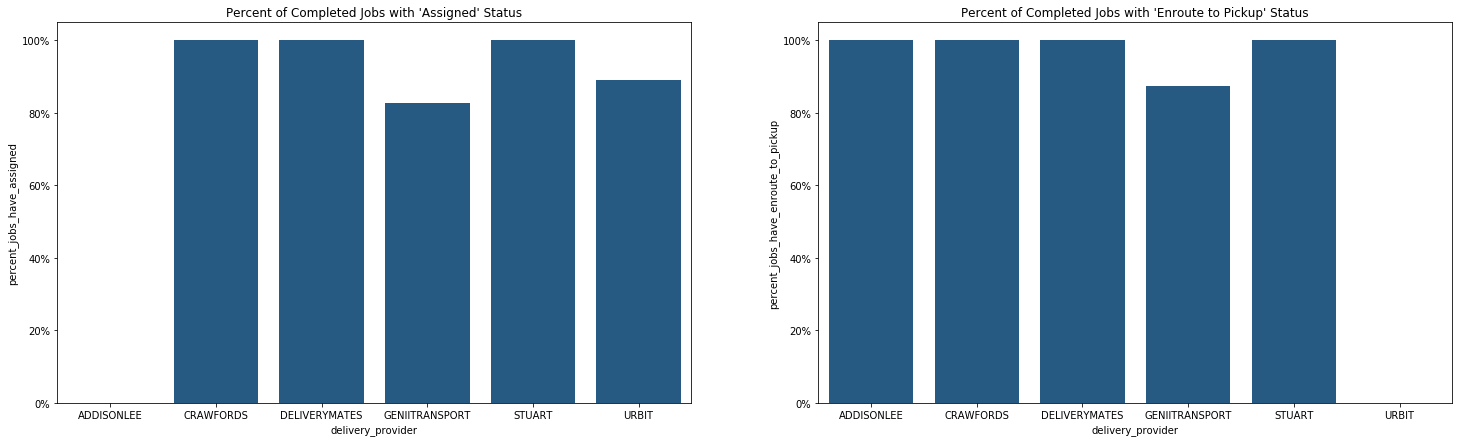

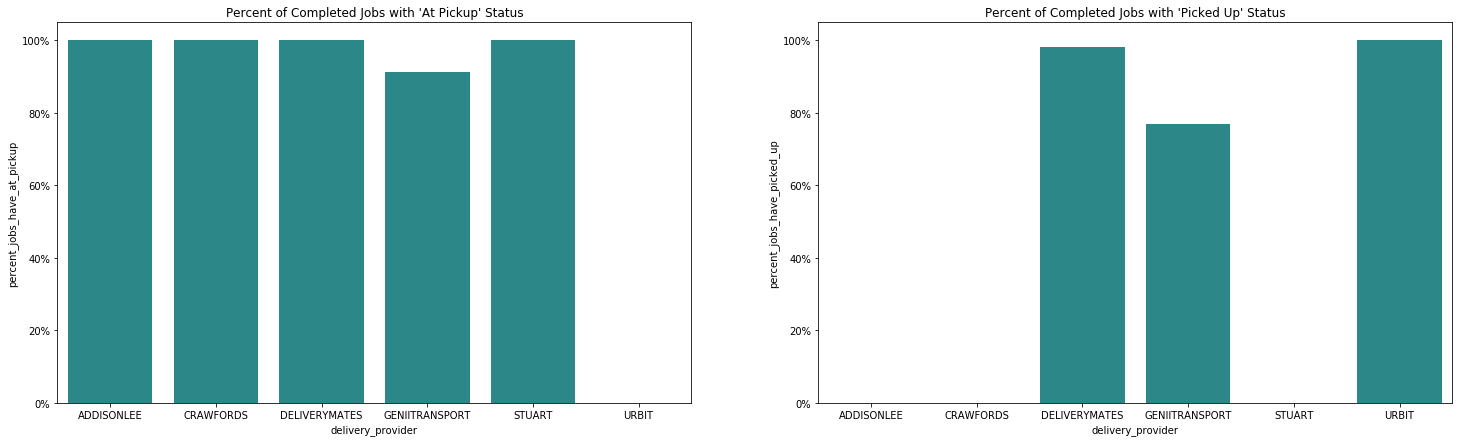

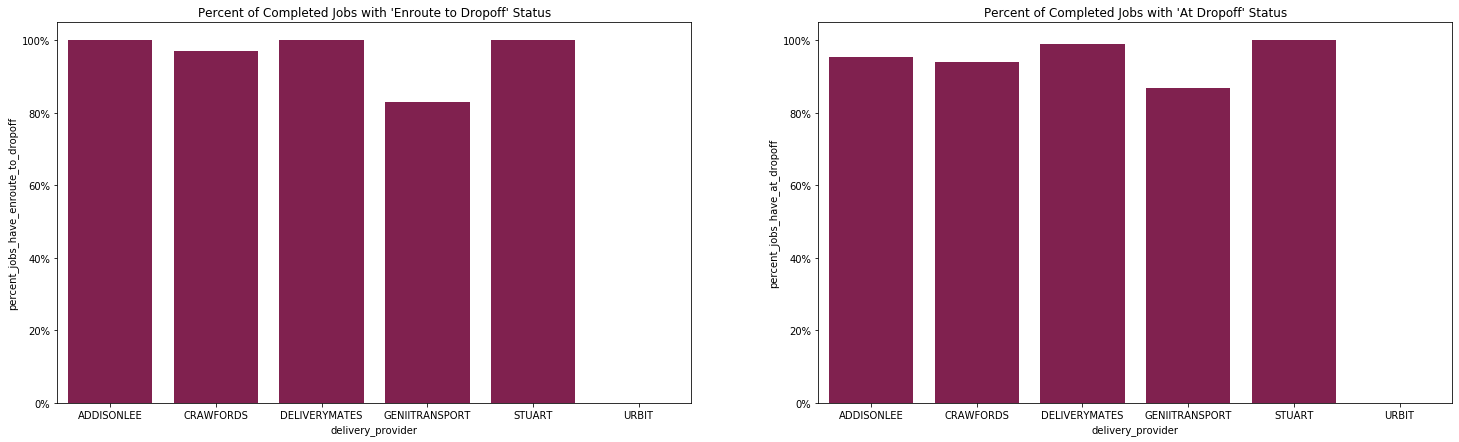

In [38]:
f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)

ax1=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_assigned'] ,ax=axes[0], color='#185c91')
ax2=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_enroute_to_pickup'] ,ax=axes[1], color = '#185c91')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title("Percent of Completed Jobs with 'Assigned' Status")
ax2.set_title("Percent of Completed Jobs with 'Enroute to Pickup' Status")

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)

ax1=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_at_pickup'] ,ax=axes[0], color='#1c9898')
ax2=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_picked_up'] ,ax=axes[1], color='#1c9898')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title("Percent of Completed Jobs with 'At Pickup' Status")
ax2.set_title("Percent of Completed Jobs with 'Picked Up' Status")

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)

ax1=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_enroute_to_dropoff'] ,ax=axes[0], color='#90114e')
ax2=sns.barplot(x = status_df5['delivery_provider'],y=status_df5['percent_jobs_have_at_dropoff'] ,ax=axes[1], color='#90114e')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_title("Percent of Completed Jobs with 'Enroute to Dropoff' Status")
ax2.set_title("Percent of Completed Jobs with 'At Dropoff' Status")



### These Graphs show the Average and Median Time's between Each Status Change, Broken down by DP

Text(0.5, 1.0, "Median Time Between 'Assigned' and 'Enroute to Pickup' Statuses (Seconds)")

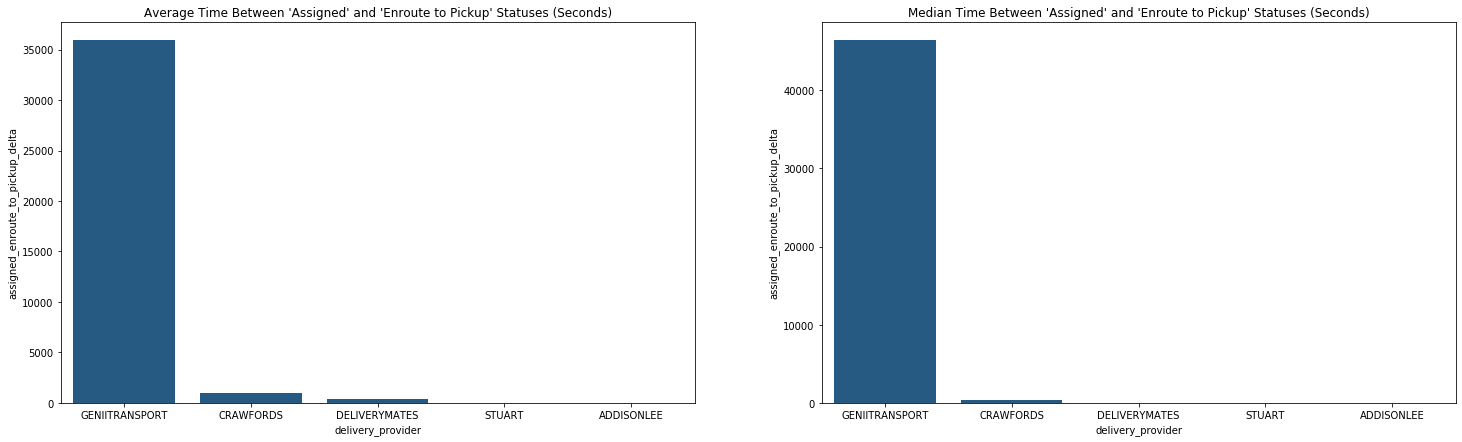

In [39]:
df6 = df6.sort_values('assigned_enroute_to_pickup_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['assigned_enroute_to_pickup_delta'],ax=axes[0], color='#185c91')
df7 = df7.sort_values('assigned_enroute_to_pickup_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['assigned_enroute_to_pickup_delta'],ax=axes[1], color='#185c91')
ax1.set_title("Average Time Between 'Assigned' and 'Enroute to Pickup' Statuses (Seconds)")
ax2.set_title("Median Time Between 'Assigned' and 'Enroute to Pickup' Statuses (Seconds)")

Text(0.5, 1.0, "Median Time Between Enroute to Pickup' and 'At Pickup' Statuses (Seconds)")

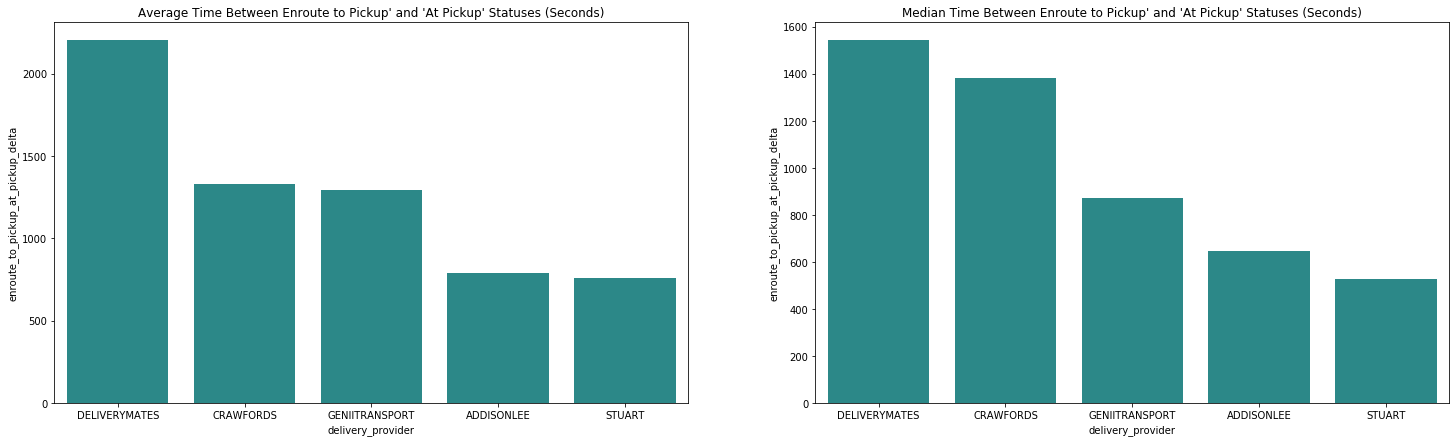

In [40]:
df6 = df6.sort_values('enroute_to_pickup_at_pickup_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['enroute_to_pickup_at_pickup_delta'],ax=axes[0], color='#1c9898')
df7 = df7.sort_values('enroute_to_pickup_at_pickup_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['enroute_to_pickup_at_pickup_delta'],ax=axes[1], color='#1c9898')
ax1.set_title("Average Time Between Enroute to Pickup' and 'At Pickup' Statuses (Seconds)")
ax2.set_title("Median Time Between Enroute to Pickup' and 'At Pickup' Statuses (Seconds)")

Text(0.5, 1.0, "Median Time Between At Pickup' and 'Picked Up' Statuses (Seconds)")

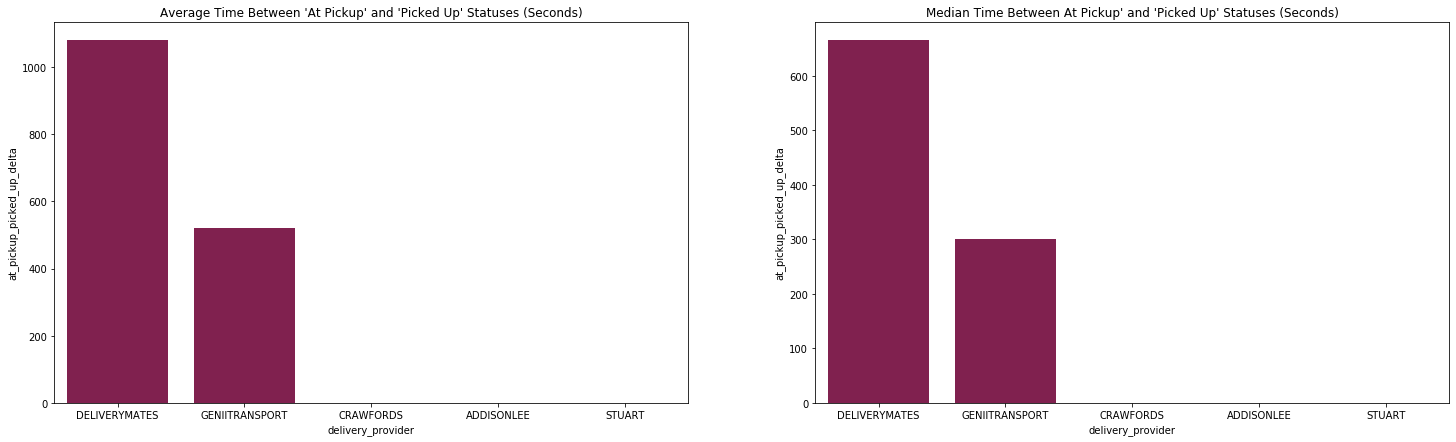

In [41]:
df6 = df6.sort_values('at_pickup_picked_up_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['at_pickup_picked_up_delta'],ax=axes[0], color='#90114e')
df7 = df7.sort_values('at_pickup_picked_up_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['at_pickup_picked_up_delta'],ax=axes[1], color='#90114e')
ax1.set_title("Average Time Between 'At Pickup' and 'Picked Up' Statuses (Seconds)")
ax2.set_title("Median Time Between At Pickup' and 'Picked Up' Statuses (Seconds)")



Text(0.5, 1.0, "Median Time Between At Pickup' and 'Enroute to Dropoff' Statuses (Seconds)")

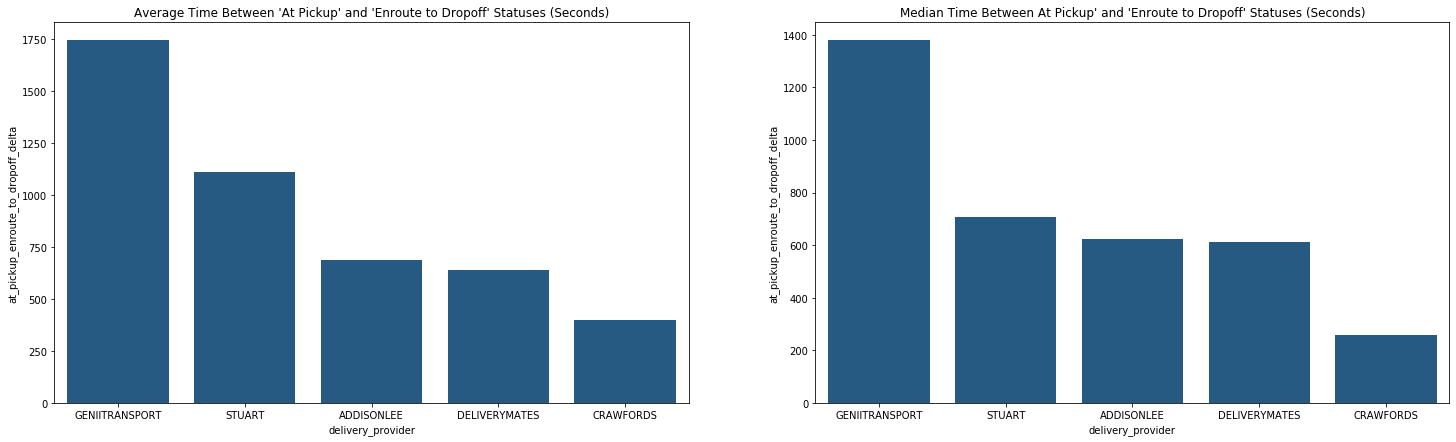

In [42]:
df6 = df6.sort_values('at_pickup_enroute_to_dropoff_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['at_pickup_enroute_to_dropoff_delta'],ax=axes[0], color='#185c91')
df7 = df7.sort_values('at_pickup_enroute_to_dropoff_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['at_pickup_enroute_to_dropoff_delta'],ax=axes[1], color='#185c91')
ax1.set_title("Average Time Between 'At Pickup' and 'Enroute to Dropoff' Statuses (Seconds)")
ax2.set_title("Median Time Between At Pickup' and 'Enroute to Dropoff' Statuses (Seconds)")



Text(0.5, 1.0, "Median Time Between 'Picked Up' and 'Enroute to Dropoff' Statuses (Seconds)")

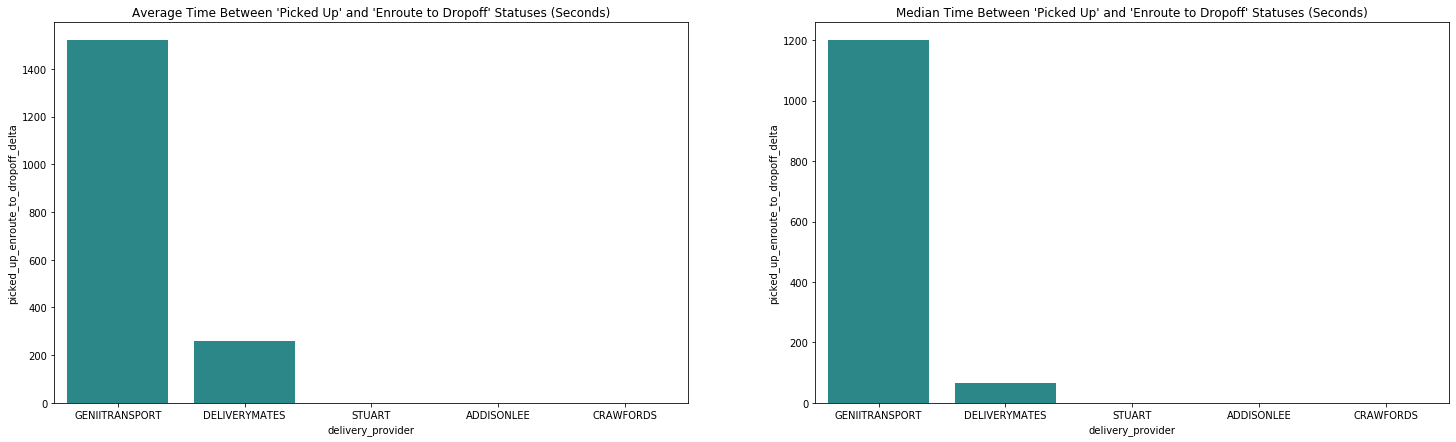

In [43]:
df6 = df6.sort_values('picked_up_enroute_to_dropoff_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['picked_up_enroute_to_dropoff_delta'],ax=axes[0], color='#1c9898')
df7 = df7.sort_values('picked_up_enroute_to_dropoff_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['picked_up_enroute_to_dropoff_delta'],ax=axes[1], color='#1c9898')
ax1.set_title("Average Time Between 'Picked Up' and 'Enroute to Dropoff' Statuses (Seconds)")
ax2.set_title("Median Time Between 'Picked Up' and 'Enroute to Dropoff' Statuses (Seconds)")




Text(0.5, 1.0, "Median Time Between Enroute to Dropoff' and 'At Dropoff' Statuses (Seconds)")

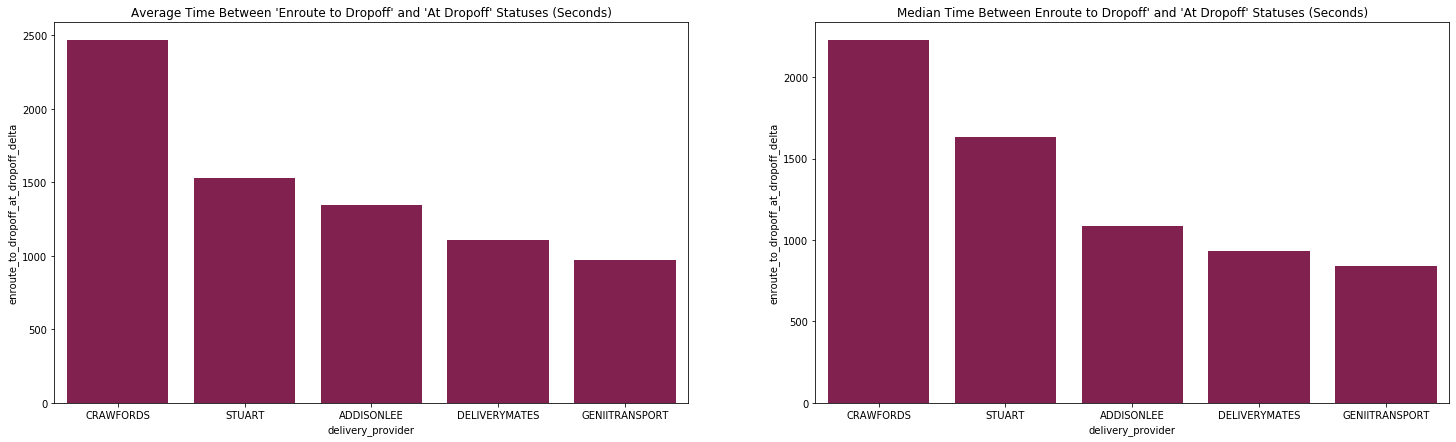

In [44]:
df6 = df6.sort_values('enroute_to_dropoff_at_dropoff_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['enroute_to_dropoff_at_dropoff_delta'],ax=axes[0], color='#90114e')
df7 = df7.sort_values('enroute_to_dropoff_at_dropoff_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['enroute_to_dropoff_at_dropoff_delta'],ax=axes[1], color='#90114e')
ax1.set_title("Average Time Between 'Enroute to Dropoff' and 'At Dropoff' Statuses (Seconds)")
ax2.set_title("Median Time Between Enroute to Dropoff' and 'At Dropoff' Statuses (Seconds)")




Text(0.5, 1.0, "Median Time Between 'At Dropoff' and 'Complete' Statuses (Seconds)")

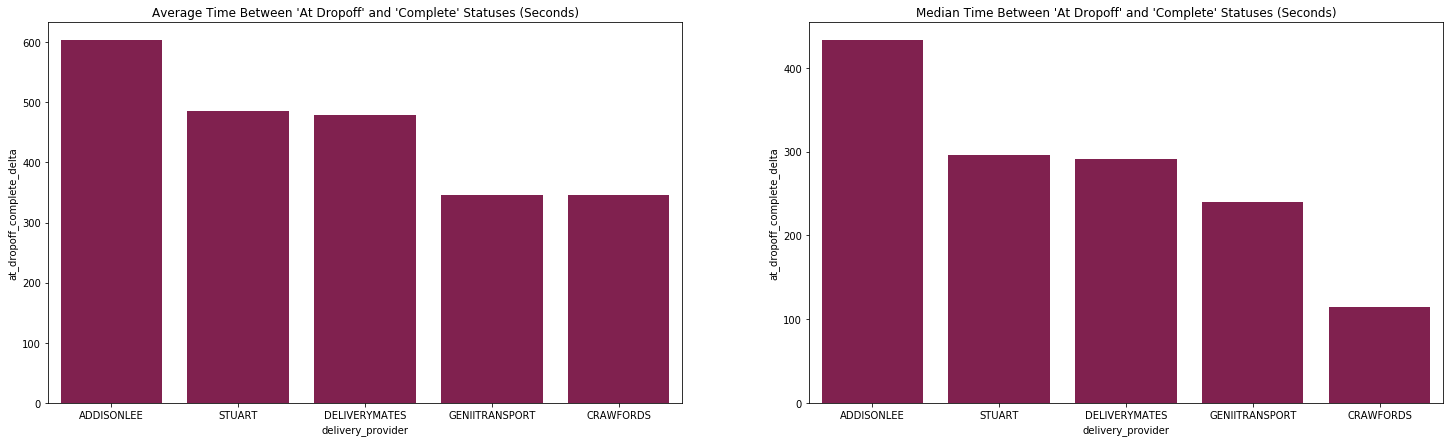

In [45]:
df6 = df6.sort_values('at_dropoff_complete_delta', ascending=False)

f, axes = plt.subplots(1, 2, figsize=(25, 7), sharex=True)
ax1 = sns.barplot(x=df6['delivery_provider'], y=df6['at_dropoff_complete_delta'],ax=axes[0], color='#90114e')
df7 = df7.sort_values('at_dropoff_complete_delta', ascending=False)
ax2 = sns.barplot(x=df7['delivery_provider'], y=df7['at_dropoff_complete_delta'],ax=axes[1], color='#90114e')
ax1.set_title("Average Time Between 'At Dropoff' and 'Complete' Statuses (Seconds)")
ax2.set_title("Median Time Between 'At Dropoff' and 'Complete' Statuses (Seconds)")


# Distribution of Times Between Status Changes

### Assigned to Enroute to Pickup Distribution

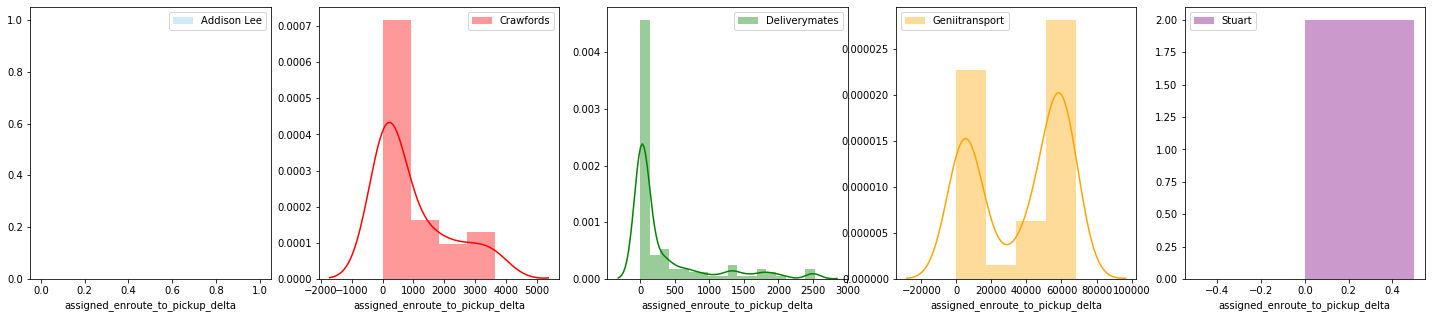

In [46]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
al = df5[df5['delivery_provider']=='ADDISONLEE']
crawfords = df5[df5['delivery_provider']=='CRAWFORDS']
otl = df5[df5['delivery_provider']=='DELIVERYMATES']
genii = df5[df5['delivery_provider']=='GENIITRANSPORT']
stuart = df5[df5['delivery_provider']=='STUART']
ax1=sns.distplot(al['assigned_enroute_to_pickup_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['assigned_enroute_to_pickup_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['assigned_enroute_to_pickup_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['assigned_enroute_to_pickup_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['assigned_enroute_to_pickup_delta'] , color="purple", label="Stuart", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### Enroute to Pickup to At Pickup Distribution (Seconds)

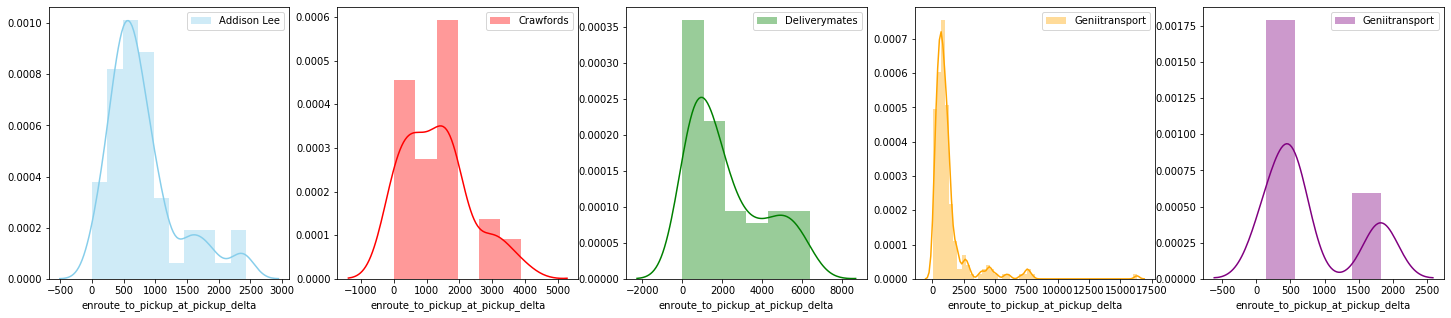

In [47]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
ax1=sns.distplot(al['enroute_to_pickup_at_pickup_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['enroute_to_pickup_at_pickup_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['enroute_to_pickup_at_pickup_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['enroute_to_pickup_at_pickup_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['enroute_to_pickup_at_pickup_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### At Pickup to Picked Up Distribution (Seoconds)

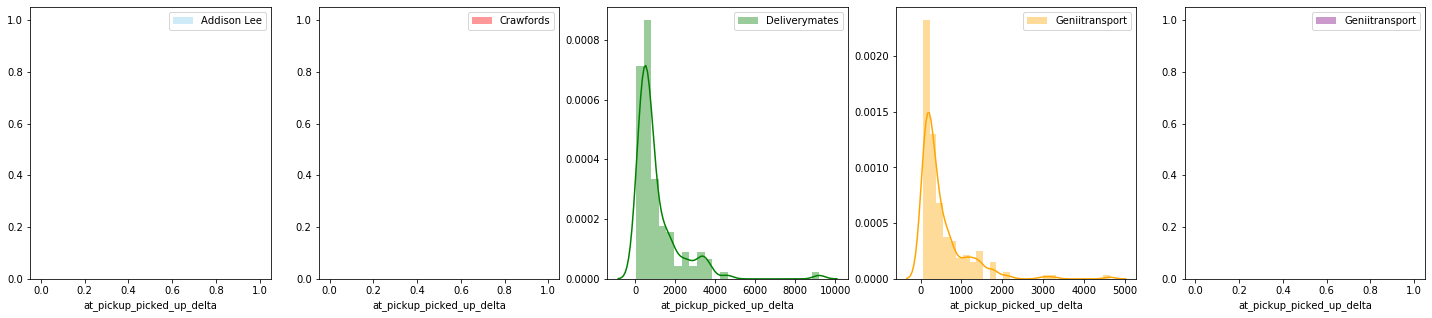

In [48]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
ax1=sns.distplot(al['at_pickup_picked_up_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['at_pickup_picked_up_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['at_pickup_picked_up_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['at_pickup_picked_up_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['at_pickup_picked_up_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### At Pickup to Enroute to Dropoff Distribution Seconds

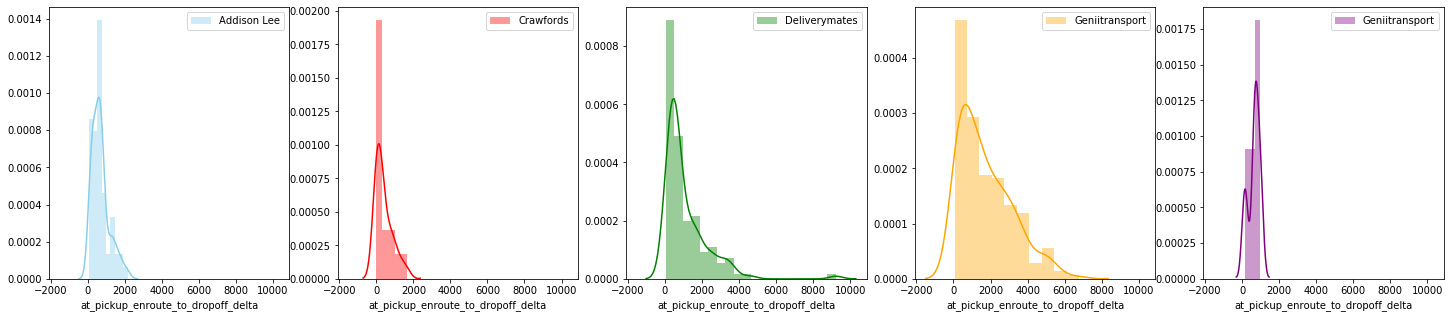

In [49]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)
ax1=sns.distplot(al['at_pickup_enroute_to_dropoff_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['at_pickup_enroute_to_dropoff_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['at_pickup_enroute_to_dropoff_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['at_pickup_enroute_to_dropoff_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['at_pickup_enroute_to_dropoff_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### Picked up to Enroute to Dropoff Distribution (Seconds)

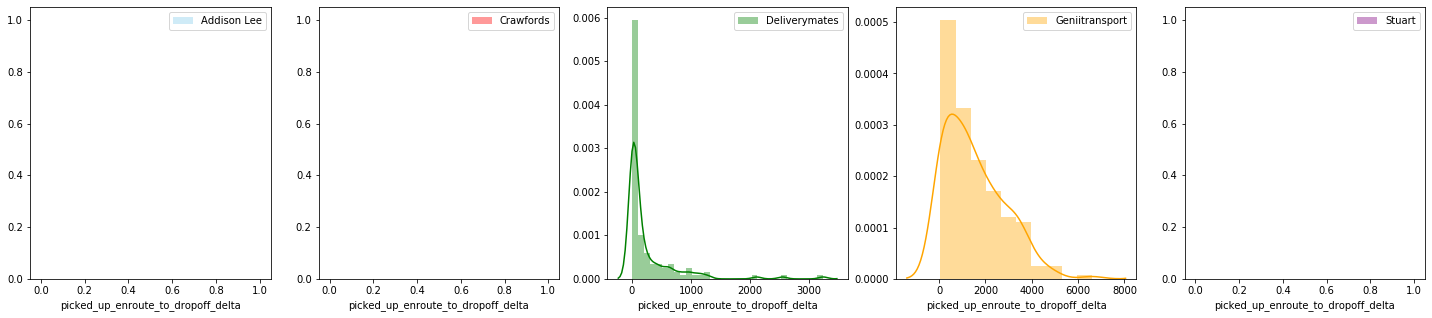

In [50]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False)
ax1=sns.distplot(al['picked_up_enroute_to_dropoff_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['picked_up_enroute_to_dropoff_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['picked_up_enroute_to_dropoff_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['picked_up_enroute_to_dropoff_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['picked_up_enroute_to_dropoff_delta'] , color="purple", label="Stuart", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### Enroute to Dropoff to At Dropoff Distribution (Seconds)

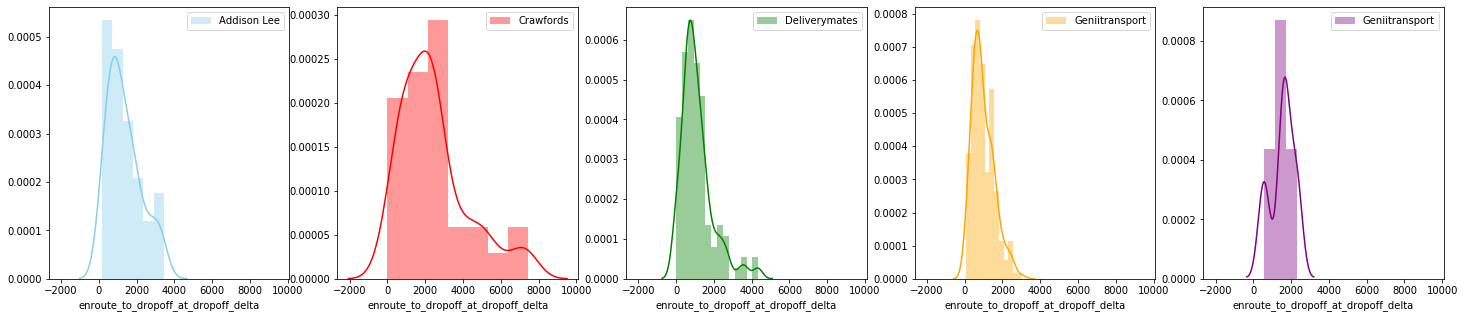

In [51]:
f, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)
ax1=sns.distplot(al['enroute_to_dropoff_at_dropoff_delta'] , color="skyblue", label="Addison Lee", ax=axes[0])
ax2=sns.distplot(crawfords['enroute_to_dropoff_at_dropoff_delta'] , color="red", label="Crawfords", ax=axes[1])
ax3=sns.distplot(otl['enroute_to_dropoff_at_dropoff_delta'] , color="green", label="Deliverymates", ax=axes[2])
ax4=sns.distplot(genii['enroute_to_dropoff_at_dropoff_delta'] , color="orange", label="Geniitransport", ax=axes[3])
ax5=sns.distplot(stuart['enroute_to_dropoff_at_dropoff_delta'] , color="purple", label="Geniitransport", ax=axes[4])
ax1 = ax1.legend()
ax2 = ax2.legend()
ax3 = ax3.legend()
ax4 = ax4.legend()
ax5 = ax5.legend()

### At Dropoff to Complete Distribution Seconds

# 